
<h1 align=center><font size = 5> Pearson similarity Recommender</font></h1>

---

<center>
  <img src="https://bobliu.io/assets/img/cards.509a5045.jpg" width="800" height="300">
</center>


## Objetivo de este Notebook

1. Cargar y preprocesar un Dataset.
2. Realizar un sistema de recomendación basado en Pearson Similarity.
3. Comprobar el performance del sistema.

## Tabla de Contenidos

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
    
1. <a href="#item31">Contexto</a>  
2. <a href="#item32">Descargar y preparar el Dataset</a>  
6. <a href="#item34">Entrenamiento del modelo</a>  
6. <a href="#item34">Validación del modelo</a>  

</font>
</div>

## 1. Contexto


El conjunto de datos MovieLens es uno de los conjuntos de datos de recomendación más populares y ampliamente utilizados en la investigación de sistemas de recomendación. Fue creado por el GroupLens Research Project en la Universidad de Minnesota para impulsar la investigación en sistemas de recomendación, proporcionando un recurso valioso para la comunidad académica y promoviendo el desarrollo y la comprensión de tecnologías de recomendación personalizada.


<b>Descripción de datos</b>

El conjunto de datos MovieLens contiene información sobre:

<b>Películas:</b> Detalles sobre las películas, incluyendo su título, género y año de lanzamiento.

<b>Usuarios:</b> Perfiles de los usuarios que han calificado y/o etiquetado las películas, incluyendo su ID y otros detalles demográficos opcionales.

<b>Calificaciones:</b> Calificaciones numéricas que los usuarios asignan a las películas en una escala de 1 a 5.

<b>Etiquetas:</b> Palabras clave o tags proporcionados por los usuarios para describir el contenido o la esencia de las películas.

El conjunto de datos es ampliamente utilizado con fines académicos y de investigación, siendo una referencia en el diseño y evaluación de sistemas de recomendación de películas. También es útil para el análisis de tendencias y comportamientos en la visualización de películas y la interacción del usuario con el contenido.

<strong>Puede consultar este [link](https://grouplens.org/datasets/movielens/) para leer más sobre la fuente de datos MovieLens proporcionada por GroupLens Research en la Universidad de Minnesota.</strong>

## 2. Descargar y preparar Dataset

In [1]:
# Descargar el dataset Movielens
!curl -o dataset.zip "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
!unzip dataset.zip
!ls -la

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  1658k      0 --:--:-- --:--:-- --:--:-- 1658k
Archive:  dataset.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  
total 976
drwxr-xr-x 1 root root   4096 Oct  7 02:05 .
drwxr-xr-x 1 root root   4096 Oct  7 02:04 ..
drwxr-xr-x 4 root root   4096 Oct  5 19:32 .config
-rw-r--r-- 1 root root 978202 Oct  7 02:05 dataset.zip
drwxr-xr-x 2 root root   4096 Sep 26  2018 ml-latest-small
drwxr-xr-x 1 root root   4096 Oct  5 19:33 sample_data


In [2]:
# Principales librerías
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") # Turn off warnings


In [3]:
links   = pd.read_csv("ml-latest-small/links.csv")
movies  = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")
tags    = pd.read_csv("ml-latest-small/tags.csv")


In [ ]:
links.head()

In [ ]:
movies.head()

In [ ]:
ratings.head()

In [ ]:
tags.head()

In [4]:
print("  Movies: {} \n  Ratings: {}".format(len(movies), len(ratings)))


  Movies: 9742 
  Ratings: 100836


In [5]:
# Fusiona ambos datasets basados en la columna 'movieId'
data = pd.merge(ratings, movies, on='movieId')

In [6]:
movie_titles = data['title'].unique().tolist()
movie_ids = data['movieId'].unique().tolist()


In [7]:
# Crear matriz pivotada de usuarios y películas
user_movie_rating = data.pivot_table(index='userId', columns='title', values='rating')


In [8]:
user_movie_rating.shape

(610, 9719)

In [9]:
user_movie_rating.isnull().sum().sort_values()

title
Forrest Gump (1994)                          281
Shawshank Redemption, The (1994)             293
Pulp Fiction (1994)                          303
Silence of the Lambs, The (1991)             331
Matrix, The (1999)                           332
                                            ... 
King Kong Lives (1986)                       609
Kindred, The (1986)                          609
Kindergarten Cop 2 (2016)                    609
King and I, The (1999)                       609
À nous la liberté (Freedom for Us) (1931)    609
Length: 9719, dtype: int64

Elegimos un rango de items (las 500 pelicuas mas vistas, pues hay pocos usuarios)

In [10]:
#500 películas más vistas
movies_pop = user_movie_rating.isnull().sum().sort_values()[:500]
movies_pop.head()

title
Forrest Gump (1994)                 281
Shawshank Redemption, The (1994)    293
Pulp Fiction (1994)                 303
Silence of the Lambs, The (1991)    331
Matrix, The (1999)                  332
dtype: int64

In [11]:
movies_pop.tail()

title
Lethal Weapon 3 (1992)          564
Beverly Hills Cop (1984)        564
Phenomenon (1996)               564
M*A*S*H (a.k.a. MASH) (1970)    564
The Butterfly Effect (2004)     564
dtype: int64

In [12]:
user_movie_rating.shape

(610, 9719)

In [13]:
user_movie_rating = user_movie_rating[movies_pop.index.tolist()]

In [14]:
user_movie_rating = user_movie_rating.reset_index()

In [15]:
user_movie_rating.shape

(610, 501)

Muestreo

In [ ]:
user_movie_rating

title,userId,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),...,Analyze This (1999),Mortal Kombat (1995),Gran Torino (2008),"Simpsons Movie, The (2007)",Rumble in the Bronx (Hont faan kui) (1995),Lethal Weapon 3 (1992),Beverly Hills Cop (1984),Phenomenon (1996),M*A*S*H (a.k.a. MASH) (1970),The Butterfly Effect (2004)
0,1,4.0,NaN,3.0,4.0,5.0,5.0,4.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
1,2,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,1.0,5.0,1.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,3.0,5.0,NaN,NaN,NaN,NaN,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,4.0,3.5,5.0,4.5,5.0,4.5,2.5,3.5,3.5,...,3.0,NaN,4.5,3.5,NaN,0.5,2.5,NaN,NaN,NaN
606,607,NaN,5.0,3.0,5.0,5.0,3.0,4.0,5.0,4.0,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,3.0,NaN
607,608,3.0,4.5,5.0,4.0,5.0,3.5,3.0,4.0,3.0,...,NaN,0.5,NaN,NaN,NaN,3.0,2.5,3.0,NaN,4.0
608,609,4.0,4.0,4.0,NaN,NaN,NaN,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
user_movie_rating.shape

(610, 501)

In [16]:
from sklearn.model_selection import train_test_split

# Convertir la matriz pivotada en un DataFrame y dividir en train y test
train_data, test_data = train_test_split(user_movie_rating, test_size=0.2, random_state=42)


In [17]:
# Volver a crear matrices pivotadas para entrenamiento y prueba
train_data_matrix = train_data.fillna(0) #Recomendación de fillna(0)
test_data_matrix = test_data.fillna(0)

In [18]:
#Tamaño de matrices train y test
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(488, 501)
(122, 501)


In [19]:
test_data_matrix.head()

title,userId,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),...,Analyze This (1999),Mortal Kombat (1995),Gran Torino (2008),"Simpsons Movie, The (2007)",Rumble in the Bronx (Hont faan kui) (1995),Lethal Weapon 3 (1992),Beverly Hills Cop (1984),Phenomenon (1996),M*A*S*H (a.k.a. MASH) (1970),The Butterfly Effect (2004)
81,82,4.5,0.0,0.0,0.0,4.0,3.5,4.0,4.5,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0
218,219,0.0,5.0,4.0,4.5,5.0,5.0,4.0,0.0,4.5,...,0.0,1.5,0.0,3.5,3.5,0.0,0.0,0.0,0.0,0.0
55,56,5.0,4.0,4.0,5.0,0.0,0.0,5.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,599,3.5,4.0,5.0,3.0,5.0,5.0,4.0,3.5,4.5,...,2.5,2.5,0.0,0.0,5.0,2.0,3.5,2.5,0.0,1.5
264,265,0.0,4.0,0.0,5.0,5.0,5.0,4.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Pearson Similarity: User-User

In [20]:
# Si queremos correlacionar en base a USUARIOS, transponemos la matriz.
user_correlation = train_data_matrix.T.corr()

In [21]:
user_correlation

,23,582,287,322,132,174,338,177,158,137,...,330,214,466,121,20,71,106,270,435,102
23,1.000000,0.647152,0.644700,0.649055,0.656461,0.645976,0.659309,0.661034,0.648178,0.643802,...,0.657967,0.661683,0.646875,0.635154,0.419301,0.666649,0.636028,0.644286,0.644922,0.596156
582,0.647152,1.000000,0.989585,0.996950,0.992098,0.999549,0.991222,0.986297,0.988291,0.997981,...,0.993807,0.990023,0.999403,0.930675,0.464370,0.948400,0.979513,0.998364,0.998123,0.915113
287,0.644700,0.989585,1.000000,0.987706,0.983966,0.990026,0.982972,0.979682,0.980128,0.987917,...,0.983210,0.982962,0.990043,0.926824,0.462499,0.945502,0.970464,0.989593,0.988980,0.917051
322,0.649055,0.996950,0.987706,1.000000,0.993182,0.997335,0.988771,0.986902,0.986791,0.995693,...,0.991472,0.988583,0.997232,0.929443,0.465366,0.952981,0.981276,0.996231,0.997533,0.915238
132,0.656461,0.992098,0.983966,0.993182,1.000000,0.992170,0.984636,0.986650,0.983024,0.990508,...,0.986303,0.984270,0.992369,0.928531,0.459035,0.959737,0.977835,0.991222,0.993413,0.909833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.666649,0.948400,0.945502,0.952981,0.959737,0.948357,0.946314,0.959927,0.941482,0.946549,...,0.944754,0.949153,0.948958,0.901810,0.471052,1.000000,0.939899,0.948674,0.950094,0.890771
106,0.636028,0.979513,0.970464,0.981276,0.977835,0.979718,0.969034,0.971860,0.971132,0.977993,...,0.972553,0.969092,0.979414,0.911472,0.434726,0.939899,1.000000,0.978177,0.981233,0.899211
270,0.644286,0.998364,0.989593,0.996231,0.991222,0.998872,0.990858,0.985801,0.987127,0.997298,...,0.992880,0.989343,0.998655,0.930075,0.459616,0.948674,0.978177,1.000000,0.997154,0.913593
435,0.644922,0.998123,0.988980,0.997533,0.993413,0.998443,0.989519,0.986740,0.987995,0.996825,...,0.992120,0.988469,0.998351,0.928388,0.462483,0.950094,0.981233,0.997154,1.000000,0.913780


In [60]:
def TopMoviesUser(user_id,top):
  # Películas que el usuario ha visto
  user_movies = data[data['userId'] == user_id]
  watched_movies = user_movies[['title', 'genres', 'rating']]
  watched_movies.sort_values(by = 'rating', ascending = False, inplace = True)

  #print(f"Películas vistas por el usuario {user_id}:")
  return watched_movies.iloc[:top]

In [93]:
# Seleccionar un usuario (por ejemplo, el usuario con ID 100)
user_id = 202

# Películas que el usuario ha visto
user_movies = data[data['userId'] == user_id]
watched_movies = user_movies[['title', 'genres', 'rating']]
watched_movies.sort_values(by = 'rating', ascending = False, inplace = True)

print(f"Películas vistas por el usuario {user_id}:")
watched_movies.head(5)

Películas vistas por el usuario 202:


,title,genres,rating
50514,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western,5.0
300,Heat (1995),Action|Crime|Thriller,5.0
23090,"Sixth Sense, The (1999)",Drama|Horror|Mystery,5.0
71446,Fresh (1994),Crime|Drama|Thriller,5.0
8631,Groundhog Day (1993),Comedy|Fantasy|Romance,5.0


#Que otros usuarios tienen mayor correlación con el usuario elegido?

In [ ]:
user_correlation[[user_id]]

In [97]:
user_correlation[[user_id]].sort_values(by = user_id, ascending = False)[1:].head(10)

,202
438,0.994148
442,0.994040
459,0.993995
495,0.993909
471,0.993840
406,0.993810
557,0.993754
574,0.993726
462,0.993711
319,0.993695


### 4. Estrategia de recomendación.

Para los 5 primeros usuarios EN CONJUNTO, podríamos revisar cuales son las peliculas con mejor rating y utilizar las Top 5 rankeadas por estos usuarios y utilizarlas como recomendadas para el usuario "100"

In [99]:
Num_users = 5
User_Corr = user_correlation[[user_id]].sort_values(by = user_id, ascending = False)[1:][:Num_users]
List_User_Corr = User_Corr.index.values.tolist()
print('Usuarios con mayor correlacion:',List_User_Corr)

Usuarios con mayor correlacion: [438, 442, 459, 495, 471]


In [100]:
df_list=[]
for u in List_User_Corr:
  d=TopMoviesUser(u,5)
  df_list.append(d)

In [101]:
df_to_recommend = pd.concat(df_list)
df_to_recommend.head()

,title,genres,rating
16531,"Shawshank Redemption, The (1994)",Crime|Drama,5.0
90179,Final Fantasy VII: Advent Children (2004),Action|Adventure|Animation|Fantasy|Sci-Fi,5.0
24162,"Crouching Tiger, Hidden Dragon (Wo hu cang lon...",Action|Drama|Romance,5.0
6933,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,5.0
38247,Shrek 2 (2004),Adventure|Animation|Children|Comedy|Musical|Ro...,5.0


Peliculas recomendadas para el Usuario=202


In [102]:
df_to_recommend.groupby('title').sum('rating').sort_values(by='rating',ascending=False).head(5)

,rating
title,
"Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)",10.0
Argo (2012),5.0
Armageddon (1998),5.0
Toy Story (1995),5.0
The Gift (2015),5.0


In [70]:
%%capture
!pip install adjustText

PCA para entender la similaridad

In [71]:
# Crear matriz pivotada de usuarios y películas
user_movie_rating = data.pivot_table(index='userId', columns='title', values='rating')

#30 películas más vistas
movies_pop = user_movie_rating.isnull().sum().sort_values()[:50]

user_movie_rating = user_movie_rating[movies_pop.index.tolist()]
user_movie_rating = user_movie_rating.reset_index()

movie_correlation = user_movie_rating.fillna(0).corr()
movie_correlation = movie_correlation.reset_index()


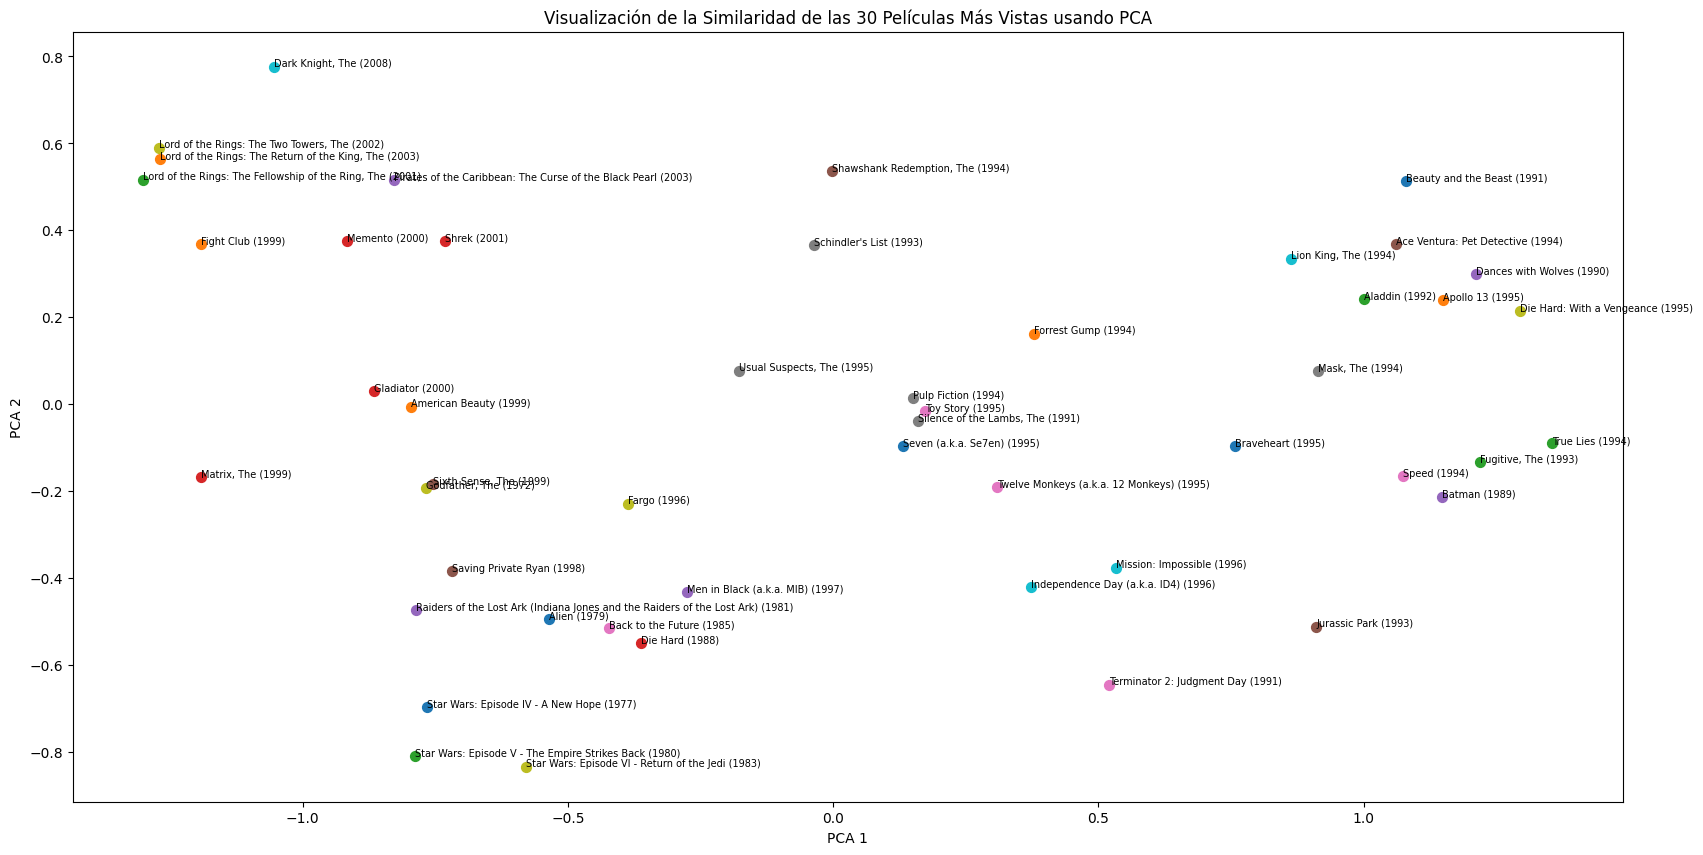

In [72]:
from sklearn.decomposition import PCA
from adjustText import adjust_text

# Aplicar PCA
pca = PCA(n_components=2)
movie_pca = pca.fit_transform(movie_correlation.drop(columns=['title', 'userId']))

# Obtener las n películas más vistas
top_30_movies = user_movie_rating.count().sort_values(ascending=False)[:50].index.tolist()
top_30_movies = list(set(top_30_movies)-set(['title', 'userId']))

# Graficar las n películas más vistas usando PCA
plt.figure(figsize=(20, 10))
for title in top_30_movies:
    idx = movie_correlation[movie_correlation['title'] == title].index[0]
    plt.scatter(movie_pca[idx, 0], movie_pca[idx, 1], s=50)
    plt.text(movie_pca[idx, 0], movie_pca[idx, 1], title, fontsize=7)

# Evitar superposición de etiquetas (si tienes adjustText instalado)
#adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de la Similaridad de las 30 Películas Más Vistas usando PCA')
plt.show()

## 4. Evaluación del modelo

In [103]:

def recommend_movies(data, user_id, movie_correlation, n_movies=3):
    # 1. Obtener las películas vistas por el usuario y sus calificaciones
    user_ratings = data[data['userId'] == user_id]

    # 2. Ordenar por calificación y tomar las n_movies películas mejor calificadas
    top_user_movies = user_ratings.sort_values(by='rating', ascending=False)['title'].head(n_movies)

    recommended = []
    for movie in top_user_movies:
        # 3. Obtener películas similares basadas en la matriz de correlación
        # Nos aseguramos de que el título de la película exista en la matriz de correlación antes de obtener recomendaciones.
        if movie in movie_correlation.columns:
            similar_movies = movie_correlation[movie].sort_values(ascending=False).index[1:n_movies+1].tolist()
            recommended.extend(similar_movies)

    # 4. Remover duplicados y retornar recomendaciones
    return list(set(recommended))

In [104]:
user_ratings = data[data['userId'] == user_id]
top_user_movies = user_ratings.sort_values(by='rating', ascending=False)['title'].head(3)

In [105]:
top_user_movies

50514    Once Upon a Time in the West (C'era una volta ...
300                                            Heat (1995)
23090                              Sixth Sense, The (1999)
Name: title, dtype: object

In [106]:
user_id_sample = 202  # ID de usuario
recommendations = recommend_movies(data, user_id_sample, movie_correlation,30)
print(recommendations)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 45, 46, 48, 49, 50]


In [98]:
movies[movies.movieId.isin(recommendations)].head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


Evaluación del hit Rate

No retirar de este cálculo a las películas que ya ha visto.

In [107]:
def recommend_most_correlated_for_user(user_ratings, movie_correlation):
    recommended_movies = []
    for movie, rating in user_ratings.iteritems():
        if not np.isnan(rating) and movie in movie_correlation.columns:
            most_correlated = movie_correlation[movie].sort_values(ascending=False).index[1]
            recommended_movies.append(most_correlated)
    return recommended_movies

# Aplicar la función a cada fila (usuario) en test_data
test_data['recommended_movies'] = test_data.apply(lambda row: recommend_most_correlated_for_user(row, movie_correlation), axis=1)

In [108]:
def compute_hit_rate(test_data):
    hits = 0
    total_recommendations = 0
    for index, row in test_data.iterrows():
        for recommended_movie in row['recommended_movies']:
            if not np.isnan(row[recommended_movie]):
                hits += 1
            total_recommendations += 1
    hit_rate = hits / total_recommendations if total_recommendations != 0 else 0
    return hit_rate

hit_rate = compute_hit_rate(test_data)
print(f"Hit Rate: {hit_rate:.4f}")

Hit Rate: 0.7279


In [109]:
# Calculando hit rate para test
test_hit_rate = hit_rate(train_data_matrix.values, movie_similarity, test_data_matrix.values)
print(f"Hit Rate (Test): {test_hit_rate:.4f}")

NameError: ignored

MAE, RMSE

In [ ]:
# Predicciones para cada película que el usuario ha calificado
def compute_predictions(row, movie_correlation):
    predictions = {}
    for movie in row.dropna().index:
        if movie != 'recommended_movies':
            predicted_rating = predict_rating(row, movie, movie_correlation)
            if not np.isnan(predicted_rating):
                predictions[movie] = predicted_rating
    return predictions

test_data['predictions'] = test_data.apply(lambda row: compute_predictions(row, movie_correlation), axis=1)

# Calcular los errores para las predicciones
def compute_errors(row):
    errors = {}
    for movie, predicted_rating in row['predictions'].items():
        real_rating = row[movie]
        if not np.isnan(real_rating):
            errors[movie] = real_rating - predicted_rating
    return errors



In [ ]:
test_data['errors'] = test_data.apply(compute_errors, axis=1)

# Calcular MAE y RMSE
all_errors = [error for movie_errors in test_data['errors'] for error in movie_errors.values()]

mae = np.mean(np.abs(all_errors))
rmse = np.sqrt(np.mean(np.square(all_errors)))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

---
## Gracias por completar este laboratorio!

<b> Tarea </b>
# Desarrollar este mismo laboratorio para que se convierta en Sistema de Recomendación User-based. Con pearson y trazar estrategia de recomendción, mostrar las recomendaciones para 1 usuario.

Enviar al correo:

jcaballeroterrazos@gmail.com

Asunto: Tarea 1 Sistemas de recomendación

fecha: 7 Oct 07:59 hrs.



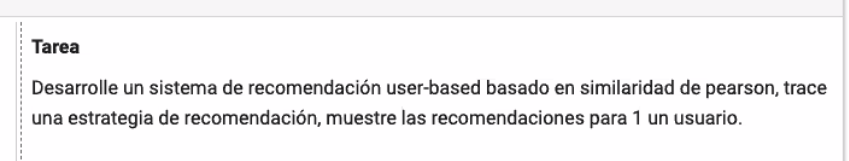